# Diagnose ensemble  initialization 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geocat.viz import util as gvutil

import datetime
import cf_units as cf
import dask

In [109]:
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

In [7]:
dir = '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/'
casename = 'f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2'

In [9]:
filenames = f"{dir}{casename}*/atm/hist/regridded_*.cam.h2a*.nc"
print(filenames)
glob.glob(filenames)

/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2*/atm/hist/regridded_*.cam.h2a*.nc


['/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.00/atm/hist/regridded_ts_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.00.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.02/atm/hist/regridded_ts_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.02.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.04/atm/hist/regridded_ts_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.04.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.03/atm/hist/regridded_ts_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.03.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.01/atm/hist/regridded_ts_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.01.cam.h2a.2021-02-09-00000.

In [11]:
ds = xr.open_mfdataset(filenames,combine='nested',concat_dim='ens')

In [12]:
ds

<xarray.Dataset>
Dimensions:  (ens: 5, time: 5, lat: 719, lon: 1440)
Coordinates:
  * time     (time) object 2021-02-08 12:00:00 ... 2021-02-12 12:00:00
  * lat      (lat) float64 -89.75 -89.5 -89.25 -89.0 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Dimensions without coordinates: ens
Data variables:
    TS       (ens, time, lat, lon) float32 dask.array<chunksize=(1, 5, 719, 1440), meta=np.ndarray>

In [33]:
ts_mean = ds.TS.mean(('lat','lon')).compute()

In [90]:
ts_us = ds.TS.sel(lon=slice(220,290),lat=slice(20, 80))

Text(0.5, 1.0, 'Global Mean TS')

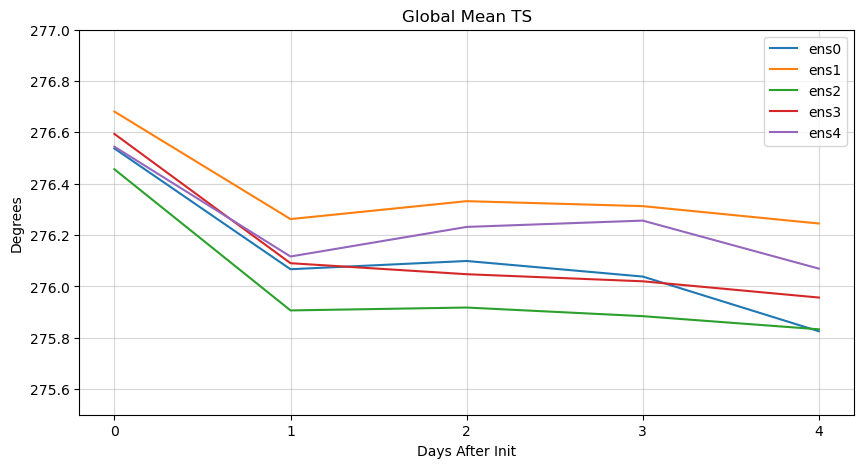

In [93]:
for ie in ds.ens:
    plt.plot(ds.time.dt.day,ts_mean.isel(ens=ie),label="ens"+str(ds.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds.time.dt.day,np.arange(5))
plt.ylim(275.5,277.0)
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('Global Mean TS')

Text(0.5, 1.0, 'CONUS Mean TS')

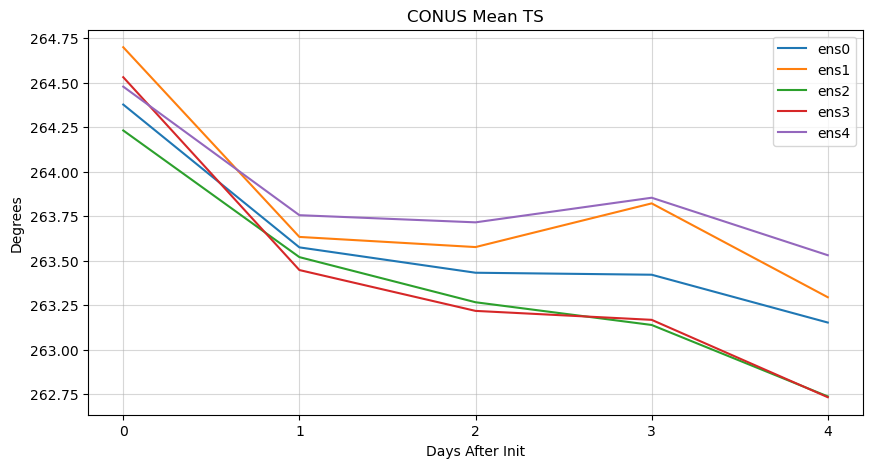

In [94]:
for ie in ds.ens:
    plt.plot(ds.time.dt.day,ts_us.mean(('lat','lon')).isel(ens=ie),label="ens"+str(ds.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds.time.dt.day,np.arange(5))
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('CONUS Mean TS')

## Plot some maps

In [136]:
## define plotting funcition

def var_plot_panels(variable, nrows, ncols, i, levels, title,colormap):
    ax1= fig.add_subplot(nrows, ncols, i, projection=ccrs.PlateCarree())
    ax1.add_feature(cfeature.COASTLINE, linewidth=4, zorder=2)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                            cmap = colormap,#'jet', #'viridis',
                           extend='both',
                           add_colorbar=False,
                           add_labels=False)
    cb = plt.colorbar(contour,
                     ax=ax1,
#                     ticks=ticks,
                     orientation='horizontal',
                     pad=0.1,
                     drawedges=True,
                     shrink=0.7,
                    # labelsize=20
                    )
        
    cb.ax.tick_params(labelsize=10)


    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=10)

    gvutil.set_axes_limits_and_ticks(ax1, xlim=(-140,-70),
                                    ylim=(20, 80),
                                    xticks=np.linspace(-140,-70, 5),
                                    yticks=np.linspace(20, 80, 7))

    gvutil.add_major_minor_ticks(ax1, labelsize=10)
    gvutil.add_lat_lon_ticklabels(ax1)


In [97]:
ts_us_diff = ts_us.copy(data = (ts_us - ts_us.isel(ens=0)).data)

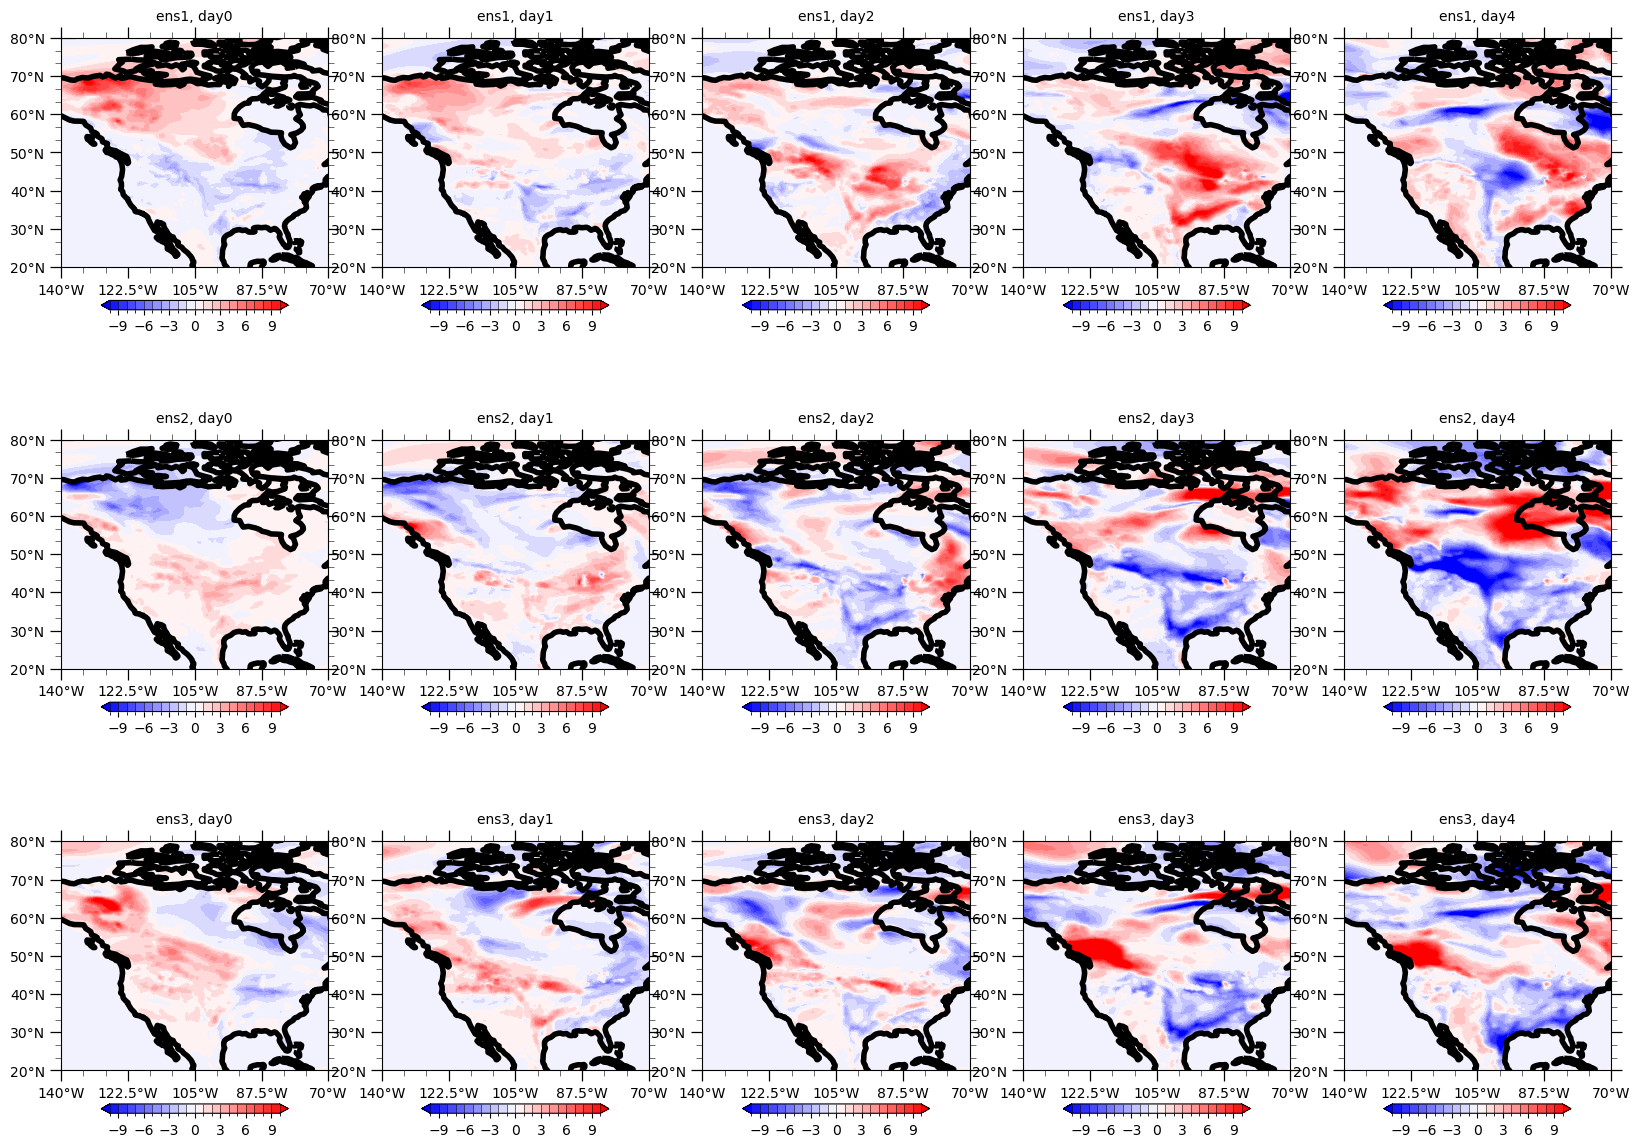

In [140]:
fig=plt.figure(figsize=(20,20))
levels=np.arange(-10,11,1)
var_plot_panels(ts_us_diff[1,0],4,5,1, levels,'ens1, day0','bwr')
var_plot_panels(ts_us_diff[1,1],4,5,2, levels,'ens1, day1','bwr')
var_plot_panels(ts_us_diff[1,2],4,5,3, levels,'ens1, day2','bwr')
var_plot_panels(ts_us_diff[1,3],4,5,4, levels,'ens1, day3','bwr')
var_plot_panels(ts_us_diff[1,4],4,5,5, levels,'ens1, day4','bwr')

var_plot_panels(ts_us_diff[2,0],4,5,6, levels,'ens2, day0','bwr')
var_plot_panels(ts_us_diff[2,1],4,5,7, levels,'ens2, day1','bwr')
var_plot_panels(ts_us_diff[2,2],4,5,8, levels,'ens2, day2','bwr')
var_plot_panels(ts_us_diff[2,3],4,5,9, levels,'ens2, day3','bwr')
var_plot_panels(ts_us_diff[2,4],4,5,10, levels,'ens2, day4','bwr')

var_plot_panels(ts_us_diff[3,0],4,5,11, levels,'ens3, day0','bwr')
var_plot_panels(ts_us_diff[3,1],4,5,12, levels,'ens3, day1','bwr')
var_plot_panels(ts_us_diff[3,2],4,5,13, levels,'ens3, day2','bwr')
var_plot_panels(ts_us_diff[3,3],4,5,14, levels,'ens3, day3','bwr')
var_plot_panels(ts_us_diff[3,4],4,5,15, levels,'ens3, day4','bwr')


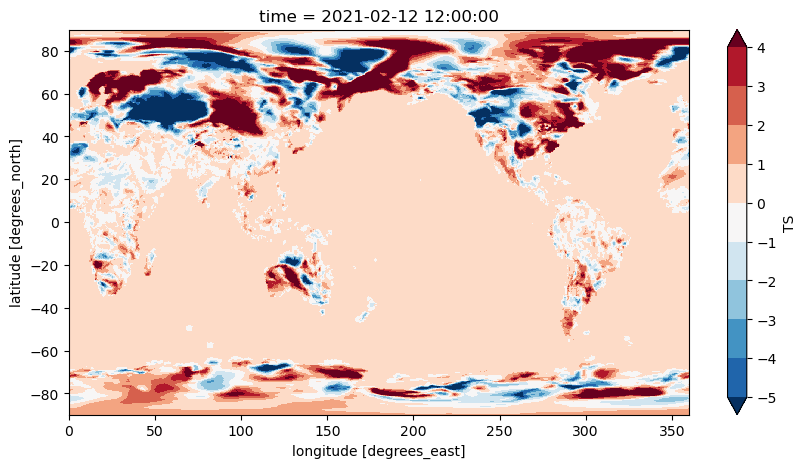

In [85]:
ts_diff[4,4].plot(levels=np.arange(-5,5))